In [1]:
import xarray as xr
import numpy as np

In [2]:
from PMMPIESM.setup import _get_path

In [3]:
ds = xr.open_dataset(_get_path('tos',prefix='ds')).rename({'ensemble':'initialization'})
control = xr.open_dataset(_get_path('tos',prefix='control')).rename({'time':'initialization'})

In [4]:
ds

<xarray.Dataset>
Dimensions:         (initialization: 12, member: 10, time: 21, x: 256, y: 220)
Coordinates:
    lon             (y, x) float64 ...
    lat             (y, x) float64 ...
  * member          (member) int64 0 1 2 3 4 5 6 7 8 9
  * initialization  (initialization) int64 3014 3023 3045 ... 3228 3237 3257
  * time            (time) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
Dimensions without coordinates: x, y
Data variables:
    tos             (time, initialization, member, y, x) float32 ...

In [5]:
control

<xarray.Dataset>
Dimensions:         (initialization: 301, x: 256, y: 220)
Coordinates:
    lon             (y, x) float64 ...
    lat             (y, x) float64 ...
  * initialization  (initialization) int64 3000 3001 3002 ... 3298 3299 3300
Dimensions without coordinates: x, y
Data variables:
    tos             (initialization, y, x) float32 ...

In [6]:
from climpred.relative_entropy import compute_relative_entropy, bootstrap_relative_entropy, plot_relative_entropy

# test PM

In [7]:
#print(ds,'\n')
#print(control)
rel_ent = compute_relative_entropy(ds, control,nmember_control=100,neofs=8)

Frozen(SortedKeysDict(OrderedDict([('initialization', 12), ('member', 10), ('time', 21), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 100, 'initialization': 12}))


/mnt/lustre01/pf/zmaw/m300524/climpred/climpred/relative_entropy.py:138: UserWarning: Warning: initialized and control_uninitialized have different coords.
  "Warning: initialized and control_uninitialized have different coords.")
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/mnt/lustre01/pf/zmaw/m300524/climpred/climpred/relative_entropy.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sigma_b, mu_x - mu_b)  # sigma_b \ (mu_x - 

In [18]:
#rel_ent.to_dataframe().unstack(0)#.plot()

In [15]:
rel_ent_threshold = bootstrap_relative_entropy(ds, control, sig=50,
                               bootstrap=50, curv=True, neofs=8,
                               nmember_control=100)

Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict(OrderedDict([('initialization', 301), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 100, 'initialization': 12}))


/mnt/lustre01/pf/zmaw/m300524/climpred/climpred/relative_entropy.py:138: UserWarning: Warning: initialized and control_uninitialized have different coords.
  "Warning: initialized and control_uninitialized have different coords.")
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/mnt/lustre01/pf/zmaw/m300524/climpred/climpred/relative_entropy.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sigma_b, mu_x - mu_b)  # sigma_b \ (mu_x - 

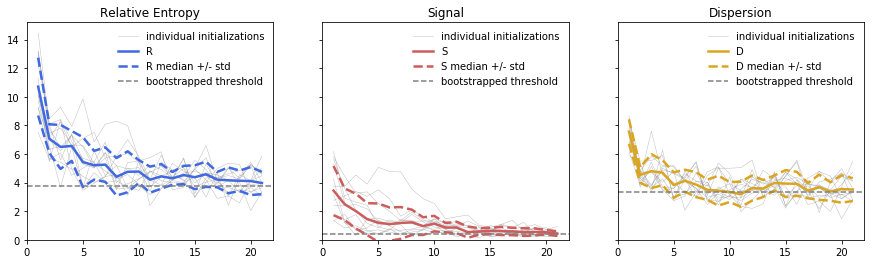

In [20]:
plot_relative_entropy(rel_ent, rel_ent_threshold=rel_ent_threshold, sharey=True, figsize=(15,4))

In [19]:
import matplotlib.pyplot as plt
from collections import OrderedDict
def plot_relative_entropy(rel_ent, rel_ent_threshold=None, **kwargs):
    """
    Plot relative entropy results.

    Args:
        rel_ent (pd.DataFrame): relative entropy from compute_relative_entropy
        rel_ent_threshold (pd.DataFrame): threshold from
                                          bootstrap_relative_entropy

    """
    colors = ['royalblue', 'indianred', 'goldenrod']
    fig, ax = plt.subplots(ncols=3, **kwargs)
    std = rel_ent.std('initialization')
    for i, dim in enumerate(['R', 'S', 'D']):
        m = rel_ent[dim].median('initialization')
        std = rel_ent[dim].std('initialization')
        ax[i].plot(rel_ent.time,rel_ent[dim].to_dataframe().unstack(0), c='gray',
                   label='individual initializations', linewidth=.5, alpha=.5)
        ax[i].plot(rel_ent.time,m, c=colors[i], label=dim, linewidth=2.5)
        ax[i].plot(rel_ent.time,(m - std), c=colors[i], label=dim + ' median +/- std',
                   linewidth=2.5, ls='--')
        ax[i].plot(rel_ent.time,(m + std), c=colors[i], label='', linewidth=2.5, ls='--')
        if rel_ent_threshold is not None:
            ax[i].axhline(y=rel_ent_threshold[dim].values,
                          label='bootstrapped threshold', c='gray', ls='--')
        handles, labels = ax[i].get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        ax[i].legend(by_label.values(), by_label.keys(), frameon=False)
    ax[0].set_title('Relative Entropy')
    ax[1].set_title('Signal')
    ax[2].set_title('Dispersion')
    ax[0].set_ylim(bottom=0)

# test DPLE, LENS
faking data with DPLE, LENS coords

In [21]:
lens = xr.concat([control]*10,dim='member').rename({'initialization':'time'}).isel(time=slice(0,65)).assign(time=np.arange(1950,2015))
lens = lens.assign(member=np.arange(lens.member.size))
print(lens)

<xarray.Dataset>
Dimensions:  (member: 10, time: 65, x: 256, y: 220)
Coordinates:
    lon      (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat      (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2010 2011 2012 2013 2014
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: x, y
Data variables:
    tos      (member, time, y, x) float32 nan nan nan nan ... nan nan nan nan


In [22]:
def _shuffle(ds, dim='initialization'):
    """Shuffle ensemble members to uninitialize the data."""
    old_dim_range = ds[dim]
    shuffled = ds.sel({dim: np.random.permutation(ds[dim])})
    if isinstance(ds, xr.DataArray):
        shuffled[dim] = old_dim_range
    elif isinstance(ds, xr.Dataset):
        shuffled = shuffled.assign({dim: old_dim_range})
    shuffled = shuffled.sortby(dim)
    return shuffled

In [23]:
#from climpred.relative_entropy import _shuffle
lens = xr.concat([_shuffle(control,'initialization') for _ in range(10)],dim='member').rename({'initialization':'time'}).isel(time=slice(0,65)).assign(time=np.arange(1950,2015))
lens = lens.assign(member=np.arange(lens.member.size))
print(lens)

<xarray.Dataset>
Dimensions:  (member: 10, time: 65, x: 256, y: 220)
Coordinates:
    lon      (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat      (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2010 2011 2012 2013 2014
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: x, y
Data variables:
    tos      (member, time, y, x) float32 nan nan nan nan ... nan nan nan nan


In [24]:
dple = xr.concat([ds]*6,'initialization').isel(initialization=slice(0,65)).isel(time=slice(0,5))
dple = dple.assign(initialization=lens.time.values)
print(dple)

<xarray.Dataset>
Dimensions:         (initialization: 65, member: 10, time: 5, x: 256, y: 220)
Coordinates:
    lon             (y, x) float64 -47.25 -47.69 -48.12 ... 131.3 132.5 133.8
    lat             (y, x) float64 76.36 76.3 76.24 ... -77.25 -77.39 -77.54
  * member          (member) int64 0 1 2 3 4 5 6 7 8 9
  * time            (time) int64 1 2 3 4 5
  * initialization  (initialization) int64 1950 1951 1952 ... 2012 2013 2014
Dimensions without coordinates: x, y
Data variables:
    tos             (time, initialization, member, y, x) float32 nan nan ... nan


In [25]:
#_bootstrap_dim(lens, dple.time.size,time_dim='time',dim='initialization',dim_label=list(dple.initialization.values))

In [26]:
#print(dple)
#print(lens)
compute_relative_entropy(dple, lens,ntime=4,nmember_control=5,neofs=3)#.head()

/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/mnt/lustre01/pf/zmaw/m300524/climpred/climpred/relative_entropy.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sigma_b, mu_x - mu_b)  # sigma_b \ (mu_x - mu_b)


<xarray.Dataset>
Dimensions:         (initialization: 65, time: 4)
Coordinates:
  * initialization  (initialization) int64 1950 1951 1952 ... 2012 2013 2014
  * time            (time) int64 1 2 3 4
Data variables:
    R               (initialization, time) float64 2.063 1.084 ... 6.966 5.214
    S               (initialization, time) float64 0.5975 0.8209 ... 6.766 4.881
    D               (initialization, time) float64 1.466 0.2634 ... 0.3333

# Understand nmember_control


 5
Frozen(SortedKeysDict(OrderedDict([('initialization', 12), ('member', 10), ('time', 21), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 5, 'initialization': 12}))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict(OrderedDict([('initialization', 301), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 5, 'initialization': 12}))


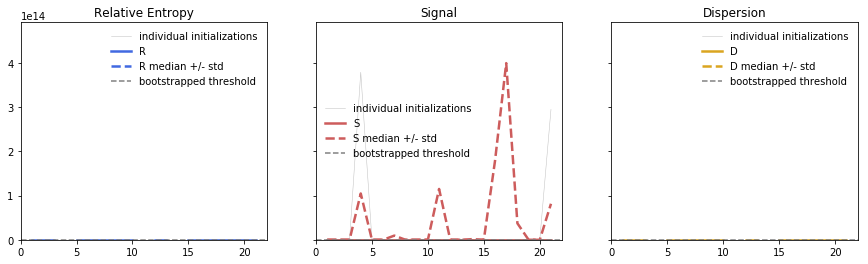


 10
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict(OrderedDict([('initialization', 301), ('x', 256), ('y', 220)])))


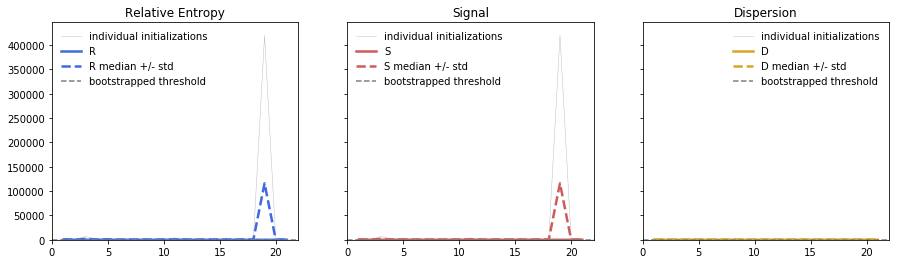


 20
Frozen(SortedKeysDict(OrderedDict([('initialization', 12), ('member', 10), ('time', 21), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 20, 'initialization': 12}))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict(OrderedDict([('initialization', 301), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 20, 'initialization': 12}))


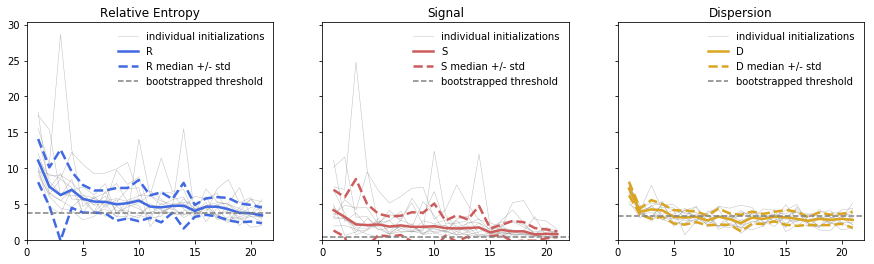


 50
Frozen(SortedKeysDict(OrderedDict([('initialization', 12), ('member', 10), ('time', 21), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 50, 'initialization': 12}))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict(OrderedDict([('initialization', 301), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 50, 'initialization': 12}))


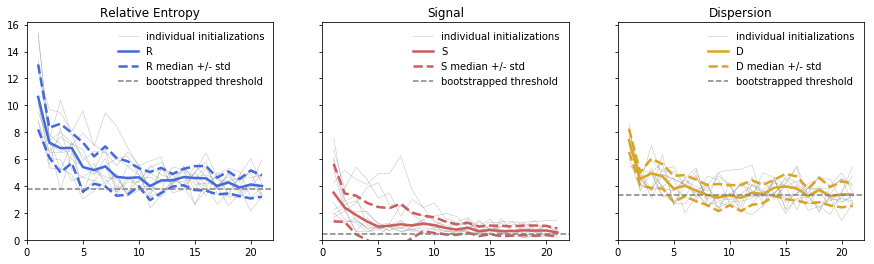


 100
Frozen(SortedKeysDict(OrderedDict([('initialization', 12), ('member', 10), ('time', 21), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 100, 'initialization': 12}))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict(OrderedDict([('initialization', 301), ('x', 256), ('y', 220)])))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 10, 'initialization': 12}))
Frozen(SortedKeysDict({'y': 220, 'x': 256, 'time': 21, 'member': 100, 'initialization': 12}))


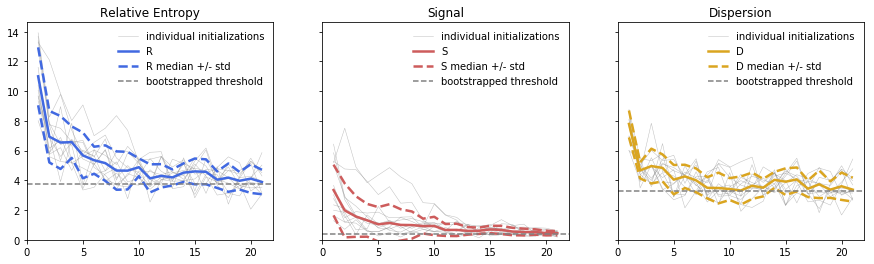

In [28]:
import warnings
warnings.filterwarnings("ignore")
neofs=8
for i in [5,10,20,50,100]:
    print('\n',i)
    rel_ent = compute_relative_entropy(ds, control,nmember_control=i,neofs=neofs)
    el_ent_threshold = bootstrap_relative_entropy(ds, control, sig=50,
                               bootstrap=50, curv=True, neofs=neofs,
                               nmember_control=i)
    plot_relative_entropy(rel_ent, rel_ent_threshold=rel_ent_threshold, sharey=True, figsize=(15,4))
    plt.show()